# JWST Ephemeris
## Where to spot the JWST in the sky?

Developed by [Jorge I. Zuluaga](mailto:jorge.zuluaga@udea.edu.co), data and sky map code adapted from [Eleanor Lutz](https://github.com/eleanorlutz/western_constellations_atlas_of_space) package.

### Package required

Dependencies:

- Astroquery.
- cartopy.

In [13]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf

from tqdm import tqdm
import datetime

from astropy import constants
from astropy.time import Time
from astroquery.jplhorizons import Horizons

import warnings
warnings.filterwarnings("ignore")

Data, constants and custom routines:

In [133]:
#Directories
skydata="./skydata/"
figdir="figures/"

#Data
stars = pd.read_csv(f'{skydata}/hygdata_processed_mag65.csv')
asterisms = pd.read_csv(f'{skydata}/asterisms.csv')
constellations = pd.read_csv(f'{skydata}/constellations.csv')
const_names = pd.read_csv(f'{skydata}/centered_constellations.csv', encoding="latin-1")

#Global properties
figsize = (20, 10)
const_color = '#ff2620'
zodiac_color = '#fcb322'
nonzodiac_color = '#77a9da'
other_color = '#979330'

#Custom routines
class LowerThresholdPlateCarree(ccrs.PlateCarree):
    ''' Add a new class to increase resolution of Geodetic vectors '''
    @property
    def threshold(self):
        return 0.01

def water_mark(ax,pos=1):
    watertext="@zuluagajorge, https://github.com/seap-udea/JWSTephem"
    if pos==1:
        ax.text(1.03,0.01,watertext,
                rotation=90,va='bottom',ha='right',transform=ax.transAxes,fontsize=8)
    else:
        ax.text(0.5,0,watertext,color='white',va='bottom',ha='center',
                transform=ax.transAxes,fontsize=10)    

def save_image(fig, savename = None, dpi=1200):
    # Remove borders on the plot axes
    for ax in fig.get_axes():
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axis('off')
        try:
            ax.set_global()
            ax.outline_patch.set_edgecolor('none')
            ax.background_patch.set_fill(False)
        except:
            pass 
        
    # Remove all padding and margins
    plt.tight_layout()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())

    # Save image
    if savename is not None:
        # Output text as editable PDF text objects instead of shapes
        matplotlib.rcParams['pdf.fonttype'] = 42
        # Force PDF to respect zorder by supressing image compositing
        matplotlib.rcParams['image.composite_image'] = False

        if savename.split('.')[-1] == 'pdf':
            pp = pdf.PdfPages(figdir+"/"+savename, keep_empty=False)
            pp.savefig(fig)
            pp.close()
        elif savename.split('.')[-1] == 'png':
            plt.savefig(figdir+"/"+savename, format='png', dpi=dpi, pad_inches=0, transparent=False)
        else:
            print("Unrecognized file format, plot not saved!")
        plt.show()
        plt.clf()
        plt.close('all')

### Get JWST Ephemeris from Horizons

Choose location and date:

In [78]:
########################
# LOCATION
########################
location="@399" #Geocentric

#Custom location
#location=dict(lon=-75,lat=6,elevation=1500)

########################
# DATE
########################
#Date interval automatic
now=datetime.datetime.now()
stop_date=now.strftime("%Y-%m-%d %H:%M:%S")
start_date=(now+datetime.timedelta(days=-10)).strftime("%Y-%m-%d %H:%M:%S")
step_date="1d"

#Custom dates
start_date="2021-12-26"
stop_date="2022-12-27"

print(f"Start date(time): {start_date}")
print(f"End date(time): {stop_date}")
print(f"Step: {step_date}")

########################
# GET POSITIONS
########################
JWST=Horizons(id='JWST',location=location, 
               epochs=dict(start=start_date,stop=stop_date,step="1d"))
ephm=JWST.ephemerides()
RAs=np.array(ephm["RA"])
DECs=np.array(ephm["DEC"])
Dates=[]
for i in range(len(ephm)):
    Dates+=[ephm[i]["datetime_str"].split()[0]]

Start date(time): 2021-12-26
End date(time): 2022-12-27
Step: 1d


#### Magnitude

First we need the absolute magnitude:

In [79]:
# Observation properties
# Source: https://www.virtualtelescope.eu/2022/01/01/the-james-webb-space-telescope-imaged-again-at-the-end-of-the-year-31-dec-2021/
date_obs=2459580.416666667
mobs=13.7

# Get ephemeris
obj=Horizons(id='JWST',location="@399",epochs=date_obs)
JWST_Earth=obj.vectors()
obj=Horizons(id='JWST', location="@10", epochs=date_obs)
JWST_Sun=obj.vectors()
dBS=JWST_Sun["range"].to("km")
dBO=JWST_Earth["range"].to("km")
do=1*constants.au
# Calculate absolute magnitude
H=(mobs-5*np.log10(dBS*dBO/do**2)).value[0]

print(f"Estimated absolute magnitude: {H}")

Estimated absolute magnitude: 25.404091841891734


Magnitude in the date range provided:

In [117]:
from matplotlib.cbook import get_sample_data
logo_white = plt.imread(f'{figdir}/webb_logo_white.png')
logo_black = plt.imread(f'{figdir}/webb_logo_black.png')

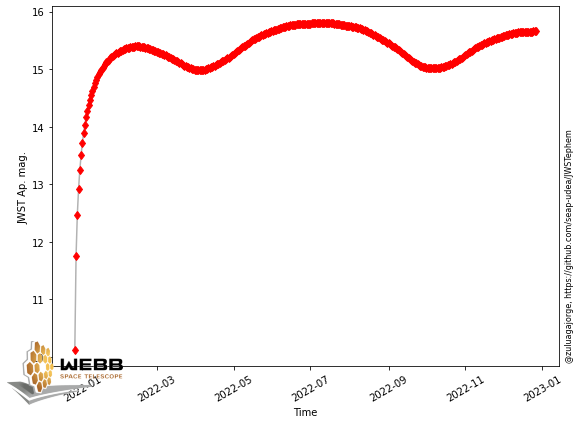

In [118]:
obj=Horizons(id='JWST',location="@399",epochs=dict(start=start_date,stop=stop_date,step=step_date))
JWST_Earth=obj.vectors()
obj=Horizons(id='JWST', location="@10", epochs=dict(start=start_date,stop=stop_date,step=step_date))
JWST_Sun=obj.vectors()
ms=[]
ts=[]
for i in range(len(JWST_Earth)):
    t=Time(JWST_Earth[i]["datetime_jd"],format="jd")
    dBS=JWST_Earth[i]["range"]*constants.au
    dBO=JWST_Sun[i]["range"]*constants.au
    ts+=[datetime.datetime.strptime(t.iso.replace(".000",""),"%Y-%m-%d %H:%M:%S")]
    ms+=[H+5*np.log10(dBS*dBO/do**2)]

fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.plot(ts,ms,'k-',alpha=0.3)
iper=1
ax.plot(ts[::iper],ms[::iper],'rd')
ax.set_xlabel("Time")
ax.set_ylabel("JWST Ap. mag.")
plt.xticks(rotation=30)
water_mark(ax)

newax = fig.add_axes([0.5,0.2,0.2,0.2], anchor='NW', zorder=1000)
newax.imshow(logo_black)
newax.axis('off')

fig.tight_layout()

### Create map

Configuration:

In [169]:
# Limiting magnitude
maglim=7

# Resolution of output map
dpi=1200

# Frequency of position and text
freq_pos = 3
freq_text = 5

Map plotting:

Numbered stars: 7723
Numbered of named stars: 131


7717it [04:57, 25.93it/s]
1189it [00:00, 6786.48it/s]


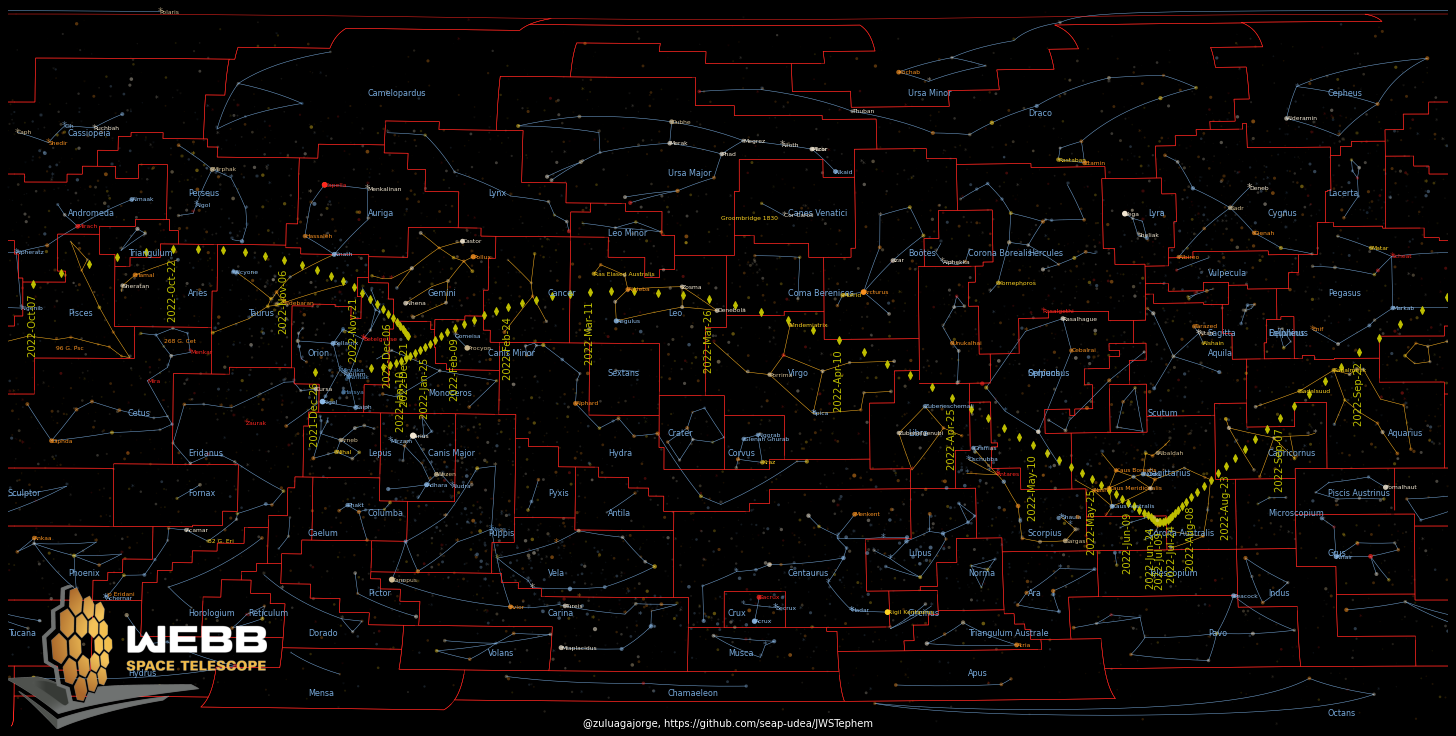

In [170]:
print(f"Numbered stars: {len(stars[pd.isnull(stars['var'])])}")
print(f"Numbered of named stars: {len(stars[pd.notnull(stars['proper'])])}")

#################################
#PLOTTING REGION
#################################
fig = plt.figure(figsize=figsize,facecolor='k')
ax = plt.axes(projection=LowerThresholdPlateCarree(180))
transformG=ccrs.Geodetic()
transformP=ccrs.PlateCarree()

#################################
#ASTERISMS
#################################
for index, row in asterisms.iterrows():
    ras = [float(x)*360/24 for x in row['ra'].replace('[', '').replace(']', '').split(',')]
    decs = [float(x) for x in row['dec'].replace('[', '').replace(']', '').split(',')]
    color = nonzodiac_color
    if row['zodiac'] == True: 
        color = zodiac_color
    assert len(asterisms)%2 == 0
    for n in range(int(len(asterisms)/2)):
        ax.plot(ras[n*2:(n+1)*2], decs[n*2:(n+1)*2], transform=transformG, color=color, lw=0.5)
    
#################################
#BOUNDARIES
#################################
for index, row in constellations.iterrows():
    ras = [float(x)*360/24 for x in row['ra'].replace('[', '').replace(']', '').split(',')]
    decs = [float(x) for x in row['dec'].replace('[', '').replace(']', '').split(',')]
    ax.plot(ras, decs, transform=transformG, lw=0.5, alpha=1, color=const_color)
    
#################################
#CONSTELLATION NAMES
#################################
for index, row in const_names.iterrows(): 
    ax.text(row['ra']*360/24, row['dec'], row['name'], 
            transform=transformG, ha='left', va='top', fontsize=8, color=nonzodiac_color)

#################################
#STARS
#################################
stars_nonvar = stars[pd.isnull(stars['var'])]
stars_nonvar = stars_nonvar[stars_nonvar['color'] != '#000000']
for index, row in tqdm(stars_nonvar.iterrows()):
    if row["mag"]>maglim:continue
    ax.scatter(row['ra']*360/24, row['dec'], transform=transformP,
           s=(6.5-row['mag'])*5, color=row['color'], lw=0, edgecolor='none', 
           alpha=min(1, ((6.5-row['mag'])*5)/(6.5*5)), zorder=6.5-row['mag'])

#################################
#VARIABLES
#################################
ax.set_global()
ax.background_patch.set_fill(False)
stars_var = stars[pd.notnull(stars['var'])]
for index, row in tqdm(stars_var.iterrows()): 
    if row["mag"]>maglim:continue
    ax.text(row['ra']*360/24, row['dec'], "*", transform=transformP,
            fontsize=(12-row['mag']), 
            alpha=max(0.1, min(1,((6.5-row['mag'])*5)/(6.5*5))), color=row['color'], ha='center', va='center') 

#################################
#NAMES
#################################
names = stars[pd.notnull(stars['proper'])]
for index, row in names.iterrows(): 
    if row["mag"]>maglim:continue
    ax.text(row['ra']*360/24, row['dec'], row['proper'], color=row['linecolor'],
            ha='left', va='center', transform=transformG,fontsize=6)

#################################
#JWST POSITION
#################################
#ax.scatter(RAs[::1],DECs[::1],marker='d',s=20,c='y',alpha=1,transform=transformP)
j=0
for i in range(len(Dates)):
    if (i%freq_pos)==0:
        ax.plot(RAs[i],DECs[i],marker='d',ms=5,color='y',alpha=1,transform=transformP)
        if (j%freq_text)==0:
            #bbox=dict(fc='k',boxstyle='square,pad=0.1'),
            ax.text(RAs[i],DECs[i],Dates[i]+"   ",color="y",rotation=90,ha='center',va='top',transform=transformG)
        j+=1

newax = fig.add_axes([0,0,0.2,0.2], anchor='NW', zorder=1000)
newax.imshow(logo_white)
newax.axis('off')
water_mark(ax,pos=0)

save_image(fig,f'JWST_position_{start_date}_{stop_date}_{step_date}.pdf',dpi=dpi)

------
That's all folks